# ПРОЕКТ "Анализ продаж компьютерных игр, исследование закономерностей и планирование рекламной кампании"

В данном проекте мы проведем исследование данных из открытых источников о продажах игр, оценках пользователей и экспертов, жанрах и платформах. 

Нашей целью является определение ключевых параметров, влияющих на успешность игры. Это позволит интернет-магазину спланировать рекламные кампании на следующий год и выделить потенциально популярный продукт.
Последовательность нашего исследования отражена в содержании:

# Содержание


[**1.** Получение и первичная обработка данных](#1)

[**2.** Исследовательский анализ данных](#2)
   

[**3.** Портрет пользователя каждого региона](#3)


[**4.** Гипотезы относительно рейтингов различных жанров и платформ.](#4)


[**5.** Общий вывод по проекту](#5)







# 1. Получение и первичная обработка данных
<a id="1"></a>

Импортируем все необходимы для работы библиотеки:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from math import factorial
import numpy as np
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy.stats import ttest_ind

Теперь можно импортировать файл и просмотреть таблицу:

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Сразу очевидно, что в названиях столбцов нужно исправить регистр и сделать все надписи в нижнем регистре:

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN




Теперь посмотрим подробнее, как обстоят дела с **пропусками** и **типом данных**:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Сразу видно, что потребуется заменить названия столбцов (исправить везде регистр), а так же поработать над заполнением пропуском. Особенно много их в оценочных столбцах `critic_score`,`user_score`,`rating`.

Оценим **количество пропусков**:

In [7]:
df.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

Совсем незначительное количество незаполнено в названиях игр(`name`), их жанре(`genre`) и дате выпуска(`year_of_release`). Это важные параметры для дальнейшего исследования, без которых строки трудно будет анализировать и проблематично подобрать им вариант заполнения. Поэтому данные строки с пропусками можно просто удалить.

In [8]:
df = df.dropna(subset=['name','year_of_release','genre'])

In [9]:
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

Итак, устранены строки с пропусками важных параметров. Теперь обратимся к **столбцам с оценками и рейтингами** игр.

Число пропусков в них достигает 50%, удалить такой объем данных мы не можем.
поэтому посмотрим для начала, какие значения встречаются в этих столбцах и определим, чем лучше заполнить пропуски.

In [10]:
df['critic_score'].value_counts()

70.0    252
71.0    248
75.0    240
80.0    235
73.0    234
       ... 
29.0      3
20.0      3
21.0      1
13.0      1
17.0      1
Name: critic_score, Length: 81, dtype: int64

Оценка критиков у нас принимает целые значения от 0 до 98. Пропуски можно заполнить артефактом типа "9999", оторый мы сможем исключать при дальнейшем анализе. Заодно можем изменить и тип данных столбца на целочисленный:

In [11]:
df['critic_score'] = df['critic_score'].fillna('9999').astype(int)

In [12]:
df['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.9       2
0.5       2
0.2       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

Оценка пользователей у нас представлена в диапазоне от 0 до 10, включая дробные значения. Так же в столбце присутствует значение 'tbd' (to be determinated),  что означает, что рейтинг еще не сформирован и по сути его нет. 

Поэтому заменим аббревиатуру 'tbd' и пропуски артефактом "9999", после чего  установим тип данных `float`:

In [13]:
df['user_score'] = df['user_score'].replace('tbd', '9999')

In [14]:
df['user_score'] = df['user_score'].fillna('9999.0').astype(float)

Обратимся к данным по рейтингам игра, какие варианты заполнения существуют:

In [15]:
df['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Варианты рейтингов представлены буквенным обозначением, поэтому сохраняем тип данных `object` и заполняем пропуски буквенным артефактом `unknown`:

In [16]:
df['rating'] = df['rating'].fillna('unknown')

 Нам осталось только поправить тип данных в столбце с **годом выпуска** игры, сделаем его целочисленным:

In [17]:
df['year_of_release'] = df['year_of_release'].astype(int)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null int64
user_score         16444 non-null float64
rating             16444 non-null object
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB







Для дальнейшего анализа показателей нам будет полезно сразу посчитать объем родаж каждой игры по всем регионам.
Для этого создадим отдельный столбец `sales_total` и запишем в него соответствующие значения:

In [19]:
df['sales_total'] = df['na_sales'] + df['eu_sales'] + df['jp_sales']

In [20]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,74.09
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,9999,9999.0,unknown,39.47
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,32.23
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,29.82
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,9999,9999.0,unknown,30.38


## Вывод: 
Мы удалили незначительную часть строк с пропусками в названиях и жанре игр (менее 2%), а так ж заменили пропуски в столбцах рейтингов и оценок артефактными значениями, которые в дальнейшем легко будет исключить из исследования.
Так же мы произвели замену типов данных, где это было необходимо, в соответствии со значениями столбцов.

Расчитан необходимый доп.параметр - сумма продаж игры по всем регионам.
Можно приступать к анализу показателей.

# 2. Исследовательский анализ данных <a id="2"></a>

## 2.1 Объемы продаж по годам
Посмотрим для начала объемы продаж игр по годам:

In [21]:
df.groupby('year_of_release')['name'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

Количество игр, выпускаемых за год, начинает неуклонно расти после 1994 года и резко падает в 2011 году.

Посмотрим, как объемы продаж игр распределяются по платформам:


In [22]:
plt_sales = df.groupby('platform')['sales_total'].sum().sort_values(ascending=False)
plt_sales


platform
PS2     1043.09
X360     876.36
Wii      813.47
PS3      796.75
DS       743.74
PS       686.89
GBA      305.27
PS4      265.79
PSP      248.77
GB       246.27
NES      245.74
3DS      244.54
XB       243.09
PC       233.88
N64      213.70
SNES     196.82
GC       191.60
XOne     145.05
2600      85.64
WiiU      76.24
PSV       47.38
SAT       33.52
GEN       27.46
DC        15.68
SCD        1.81
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: sales_total, dtype: float64

У нас определились явные лидеры - первые 6 платформ в списке принесли в разы больше прибыли, чем остальные консоли.
Отфильтруем данные по лидерам и посмотрим на графике, как их объемы продаж распределены по годам:

In [23]:
names = plt_sales.index[:6]

top_platform =  df[df['platform'].isin(names)].reset_index()
top_platform.head()


 

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,74.09
1,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,32.23
2,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,29.82
3,6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,26.92
4,7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,26.07


<a id="plot"></a>
Отобразим продажи на общем графике:

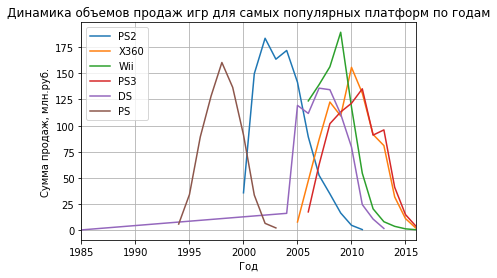

In [24]:
for name in names:
    ax=top_platform[top_platform['platform'] == name].groupby(by='year_of_release')['sales_total'].sum().plot(legend=True, label=name, grid=True)
    ax.set_ylabel('Сумма продаж, млн.руб.')
    ax.set_xlabel('Год')
    ax.set_title('Динамика объемов продаж игр для самых популярных платформ по годам')
   

### Вывод:
Из динамики продаж игр видно, что в среднем пик продаж приходится на первые 3-5 лет после выпуска консоли. 

Полный цикл жизни платформы составляет 8-10 лет. Таким образом для прогноза на 2017 год достаточно взять данные по продажам за последние 3 года и определить по ним перспективные платформы, по которым за этот период наблюдается рост объемов продаж игр.



## 2.2 Выбор наиболее перспективных платформ


Мы получили новый датафрейм с данными, которые помогут нам спрогнозировать продажи на 2017 год.
Рассмотрим его более подробно.

Для дальнейшего исследования отфильтруем таблицу, выбрав данные только за период 2014-2016 года:

In [25]:
df1 = df.query('year_of_release >= 2014')
df1

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,9999,9999.0,unknown,12.25
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,10.65
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,9999,9999.0,unknown,10.94
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,7.30
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,9999,9999.0,unknown,6.70
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,9999,9999.0,unknown,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,9999,9999.0,unknown,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,9999,9999.0,unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,9999,9999.0,unknown,0.01



Нас интересует:
- тенденции объемов продаж по платформам
- выбор наиболее перспективных, растущих по объемам родаж консолей

In [26]:
lead_sales = df1.groupby(by='platform')['sales_total'].sum().sort_values(ascending=False)
lead_sales


platform
PS4     243.67
XOne    127.84
3DS      83.00
PS3      58.81
X360     43.87
WiiU     39.82
PC       25.20
PSV      20.59
Wii       4.67
PSP       0.36
Name: sales_total, dtype: float64

Лидерами продаж за последние три года являются  **PS4, XOne и 3DS**.

За ними следуют PS3 и X360, но по [предыдущему графику](#plot) очевидно, что эти консоли уже прошли пик своей популярности почти 5 лет назад. 
Следующие по списку консоли - WiiU, Wii, PSP и PC уже выходят с рынка. 

Построим график для трех лидирующих по продажам консолей и посмотрим их тенденцию:

In [27]:
top = lead_sales.index[:3]

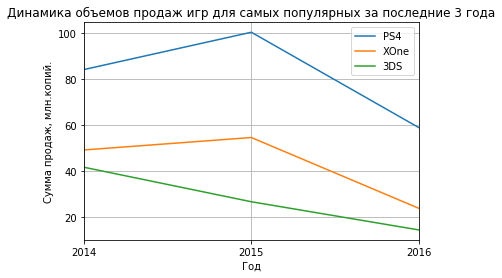

In [28]:
for x in top:
    ax=df1[df1['platform']==x].groupby(by='year_of_release')['sales_total'].sum().plot(legend=True, label=x, grid=True)
    ax.set_ylabel('Сумма продаж, млн.копий.')
    ax.set_xlabel('Год')
    ax.set_title('Динамика объемов продаж игр для самых популярных за последние 3 года')
    ax.set_xticks(range(2014,2017,1))
    
    

Из графика становится очевидно, что для платформ PS4 и XOne пик популярности пройден 1-2 года назад. 

Поскольку по [первому графику](#plot) мы опредeлили длительность жизненного цикла платформы на рынке 8-10 лет, то еще 3-4 года после пика популярности платформа продолжат приносить большую прибыль.
Поэтому в своем прогнозе на 2017 год эти 2 платформы точно стоит учитывать.

С третьим лидером - 3DS ситуация не так однозначна - продажи за 3 года в сумме высоки, на графике отчетливо видна тенденция на спад. Но на следующий год продажи составят еще ощутимую сумму копий, поэтому все 3 платформы мы оставим для дальнейших исследований.

In [29]:
df.query('platform == "3DS"').groupby(by='year_of_release')['sales_total'].sum()

year_of_release
2011    58.80
2012    48.77
2013    53.97
2014    41.75
2015    26.75
2016    14.50
Name: sales_total, dtype: float64


### Вывод:
Из полученных данных можно сделать вывод, что  в прогнозах на 2017 год необходимо учитывать платформы PS4, XOne и 3DS.



## 2.3 Распределение прибыли двух лидирующих платформ
Следующим этапом рассмотрим подробнее 2 выбранные нами консоли. Отфильтруем их данные из таблицы лидеров продаж:

In [30]:
df2 = df1.query('platform == ("PS4","XOne","3DS")')
df2.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,9999,9999.0,unknown,12.25
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,10.65
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,9999,9999.0,unknown,10.94
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,7.30
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,9999,9999.0,unknown,6.70


Построим график распределения общих продаж игр по этим платформам:

Text(0.5, 1.0, 'График распределения объемов продаж по платформам')

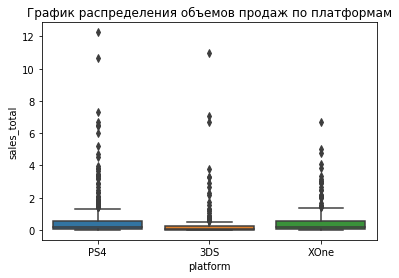

In [31]:
ax = sns.boxplot(x='platform', y='sales_total', data=df2)
ax.set_title('График распределения объемов продаж по платформам')

In [32]:
df2.query('platform=="PS4"')['sales_total'].describe()

count    376.000000
mean       0.648059
std        1.358995
min        0.010000
25%        0.050000
50%        0.160000
75%        0.580000
max       12.250000
Name: sales_total, dtype: float64

In [33]:
df2.query('platform=="XOne"')['sales_total'].describe()

count    228.000000
mean       0.560702
std        0.951956
min        0.010000
25%        0.050000
50%        0.185000
75%        0.575000
max        6.710000
Name: sales_total, dtype: float64

In [34]:
df2.query('platform=="3DS"')['sales_total'].describe()

count    212.000000
mean       0.391509
std        1.122935
min        0.010000
25%        0.030000
50%        0.080000
75%        0.230000
max       10.940000
Name: sales_total, dtype: float64

У трех платформ схожее распределение прибыли от игр: есть много выбросов в сторону бОльших значений, т.е. игр, которые значительно превосходили по популярности средний показатель. Это подтверждается так же и существенным различием значений среднего и медианы по всем платформам.


На платформе **PS4** игра в среднем продается в 160.000 копий (об этом мы судим по медиане, т.к. среднее слишком искажено большими зачениями). Продажи большинства игр (75%) не превышает 580.000 копий. Но есть игры, которые продаваемые всего в 10.000 копий или мега-популярные, которых продали более  12 млн.


У **XOne** схожие показатели средних объемов продаж - 185.000 копий,  а продажи большинства игр не превышает 575.000 копий. Среди игр так же есть отдельные варианты с минимальным объемами продаж - 10.000, а самые популярные продаются объемами почти 7 млн. копий. 

Плаформа **3DS** в среднем имеет объемы продаж 80.000 копий каждый игры, но разброс между менее продаваемыми и самыми популярынми составляет от 10.000 до почти 11 млн.копий


### Вывод:

Распределение прибыли по платформам в целом схожее: много больших выбросов по отдельным супер-популярным играм.
В среднем каждая игра для на **PS4** и **XOne** продается объемом 160-180.000 копий, у **3DS**  этот показатель в 2 раза скромнее.



## 2.4 Зависимость прибыли от оценок критиков и пользователей

Посмотрим, насколько объемы продаж по самым популярным платформам зависят от оценок критиков и пользователей.
Сначала проверим корреляцию для **PlayStation**:

In [35]:
df2.query('platform=="PS4"and critic_score!=9999')['sales_total'].corr(df2.query('platform=="PS4" and critic_score!=9999')['critic_score'])

0.4021203477635433

Мы получили коэффициент Пирсона = 0,4 - это говорит о наличии прямой зависимости между оценками критиков и объемами продаж PS4. Значение не нулевое, но гораздо меньше 1, поэтому существенного влияния оценки критиков на продажи не оказывают.
Посмотрим, как это отобразится на диаграмме рассеивания:

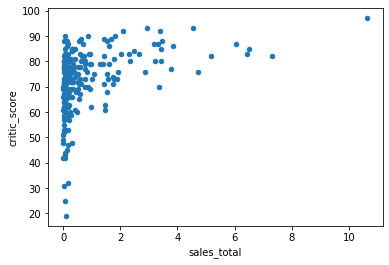

In [36]:
df2.query('platform=="PS4" and critic_score!=9999').plot(x='sales_total', y='critic_score', kind='scatter')

По диаграмме можно сделать вывод, что игры, продающиеся бОльшим тиражом, как правило имеют высокие оценки критиков (70-95 баллов). А среди игр, приносящих вышедшие в объеме мене 1 млн копий очень большой разброс оценок: игры в одном диапзоне популярности могут получать и очень низкие и очень высокие оценки. Что подтверждает наши расчеты - степень корреляции между этими показателями низкая.

Теперь рассчитаем корреляцию между продажами и оценками юзеров, построим для этих показателей диаграмму рессеивания:

In [37]:
df2.query('platform=="PS4"and user_score!=9999')['sales_total'].corr(df2.query('platform=="PS4"and user_score!=9999')['user_score'])

-0.039364345213287334

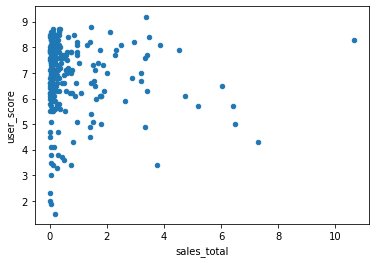

In [38]:
df2.query('platform=="PS4" and user_score!=9999').plot(x='sales_total', y='user_score', kind='scatter')

Коэффициент Пирсона ничтожно мал, что говорит об отсутствии корреляции между продажами и оценкой пользователей.
Этот вывод подтверждает и диаграмма, на которой виден большой разброс оценок и отсутствие явных взаимосвязей.




Теперь посмотрим, аналогичные показатели для платформы **XBox**:

In [39]:
df2.query('platform=="XOne" and critic_score!=9999')['sales_total'].corr(df2.query('platform=="XOne" and critic_score!=9999')['critic_score'])

0.4286498963779636

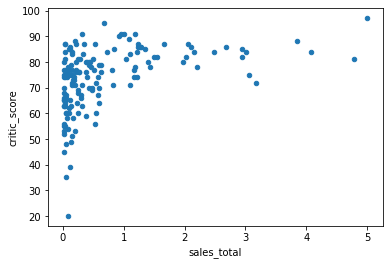

In [40]:
df2.query('platform=="XOne" and critic_score!=9999').plot(x='sales_total', y='critic_score', kind='scatter')

Между оценками критиков и продажами игр платформы XOne наблюдается прямая взаимосвязь, но коэффициент как и у PS4 гораздо меньше 1, что говорит о слабом влиянии оценок на заработки компании.

По диаграмме мы можем определить, что игры приносящие больше 1 млн.долл. как правило имеют высокие оценки киритиков. 
Но подавляющее большинство игр приносит доходы менее 1 млн.долл. и оценки в этой категории распределены совершенно хаотично.

In [41]:
df2.query('platform=="XOne"and user_score!=9999')['sales_total'].corr(df2.query('platform=="XOne" and user_score!=9999')['user_score'])

-0.07039252638189664

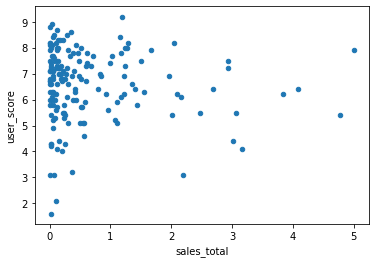

In [42]:
df2.query('platform=="XOne" and user_score!=9999').plot(x='sales_total', y='user_score', kind='scatter')


Зависимость продаж платформы XOne от оценок пользователей ничтожно мала, о чем свидетельсвует низкий коэф. Пирсона и диаграмма рассеивания: как игры, приносящие до 1 млн.долл., так и более успешные продукты компании имеют и очень низкие, и очень высокие оценки.

Посмотрим взаимосвязи оценок и продаж по третьей платформе **3DS**:

In [43]:
df2.query('platform=="3DS" and critic_score!=9999')['sales_total'].corr(df2.query('platform=="3DS" and critic_score!=9999')['critic_score'])

0.3117520311601232

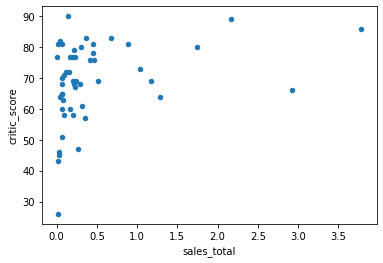

In [44]:
df2.query('platform=="3DS" and critic_score!=9999').plot(x='sales_total', y='critic_score', kind='scatter')

Низкий коэффициент Пирсона и диаграмма свидетельствуют о крайне низком влиянии оценок критиков на продажи игр 3DS.
Можно выделить слабый тренд: игры с объемом продаж более полумиллиона копий имеют оценки выше среднего. Но основная масса игр продается меньшим тиражом и в оценках у них очень большой разброс .


In [45]:
df2.query('platform=="3DS"and user_score!=9999')['sales_total'].corr(df2.query('platform=="3DS" and user_score!=9999')['user_score'])

0.21461640035191556

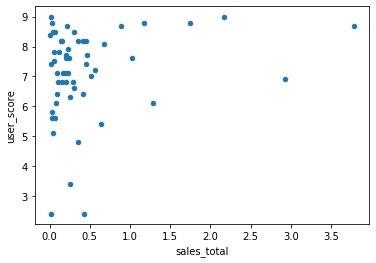

In [46]:
df2.query('platform=="3DS" and user_score!=9999').plot(x='sales_total', y='user_score', kind='scatter')

Аналогично обстоит ситуация и с оценками юзеров - продажи игр 3DS от них практически не зависят.

**ВЫВОД:**

По трем топовым платформам можно сделать вывод, что оценка критиков оказывает на продажи  игр крайне слабое значение.
Некая тенденция заметна только в категории сверхпопулярных игр - их оценки выше среднего. Но подавляющее большинство игр, чьи тиражи не превышают полумиллиона экземпляров, получают крайне разнородные оценки критиков.

Оценки пользователей не оказывают влияния на продажи игр топовых платформ.



Сравним данные с корреляцией по **другим платформам:**

Для начала получим список платформ за наш актуальный период исследования:

In [47]:
platforms = df.query('year_of_release >=2014 and platform!=("PS4", "XOne", "3DS")')['platform'].unique()
platforms

array(['WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV', 'PSP'], dtype=object)

Теперь с помощью циклов построим графики корреляции продаж и оценок:

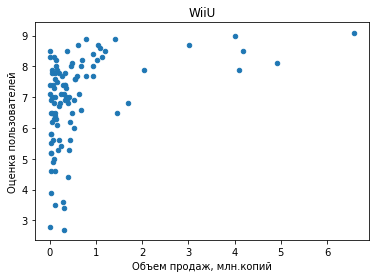

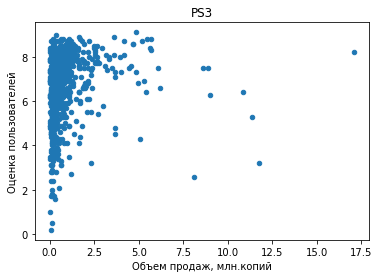

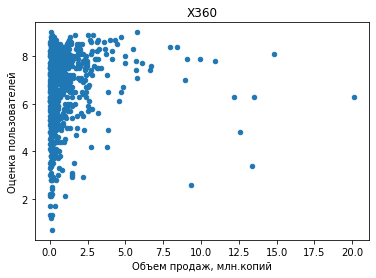

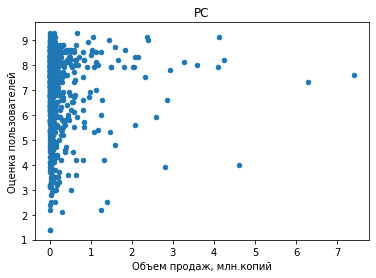

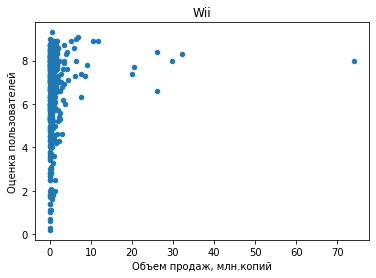

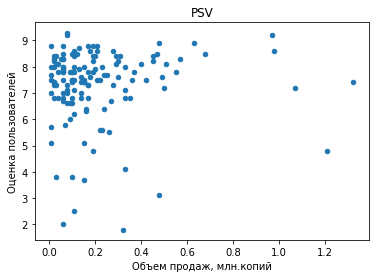

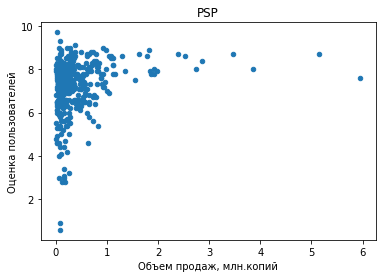

In [48]:
for name in platforms:
    ax=df[(df['platform'] == name) & (df['user_score']!=9999)].plot(x='sales_total', y='user_score', kind='scatter')
    ax.set_ylabel('Оценка пользователей')
    ax.set_xlabel('Объем продаж, млн.копий')
    ax.set_title(name)
   


На графиках  платформа `Wii`, `PSP`, `WiiU` заметна слабая тенденция - высокие оценки у самых популярынх игр. Но количество подобных игр настолько малО, относительно общего числа выпускаемых игр, что в целом мы делаем вывод: оценки юзров имеют слабое влияние на объемы продаж других платформ. Что повторяет вывод по топовым консолям.

Теперь проверим степень влияния оценок критиков:


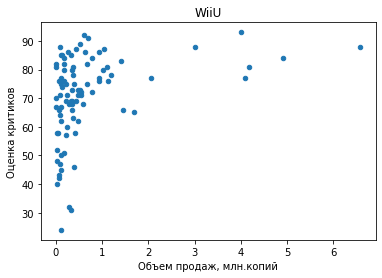

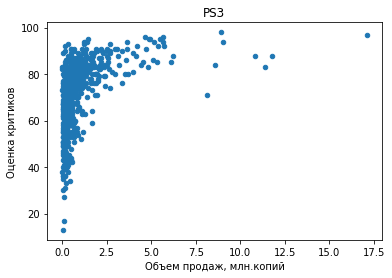

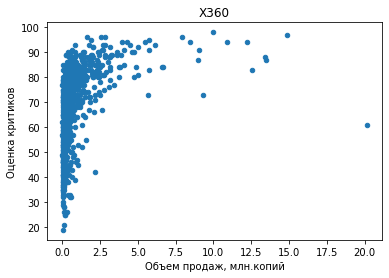

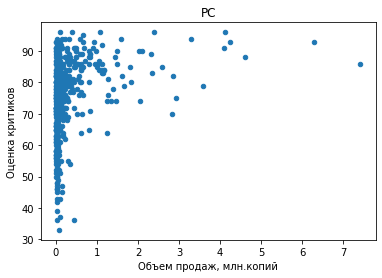

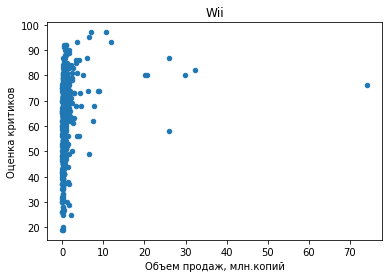

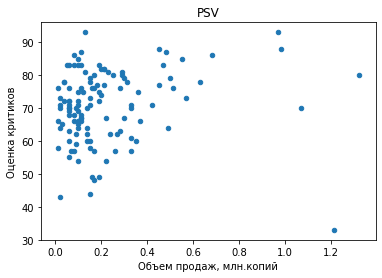

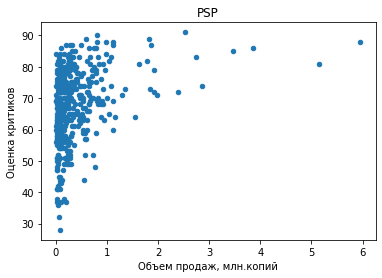

In [49]:
for name in platforms:
    ax=df[(df['platform'] == name) & (df['critic_score']!=9999)].plot(x='sales_total', y='critic_score', kind='scatter')
    ax.set_ylabel('Оценка критиков')
    ax.set_xlabel('Объем продаж, млн.копий')
    ax.set_title(name)

На диаграммах рассеяния картина соответствует выводам по топовым консолям: есть слабая положительная корреляция между оценками критиков и объемами продаж. Чем больше объем продаж - тем выше у игры оценка. 

Эта тенденция заметна только на популярных играх тиражом более полумиллиона копий. Продажи подавляющего большинства производимых игр не чувствительны к оценкам критиков и имеют в этом показателе большой размах.

## Вывод:


Зависимость объемов продаж игр по всем консолям (в том числе и самым популярным) не подверждена влиянию оценок пользователей.
Продажи самых топовых игр (как правило, с тиражом боле полумиллиона копий) имеют слабую прямую зависимость от оценок критиков. Объемы продаж подавляющего большинства производимых игр от оценок критиков так же не зависят.

## 2.5 Распределение игр по жанрам

Проверим, как в целом распределяются продажи в зависимости от жанра игры.

Для этого составим сводную таблицу, в которой рассчитаем общий доход каждого жанра в млн.долл., сумму игр, выпущенных в этом жанре, а так же средний доход с одной игры:

In [50]:
df1.groupby(by='genre')['sales_total'].agg(['sum','count','mean']).sort_values(by='sum', ascending=False)


,sum,count,mean
genre,,,
Action,176.79,619,0.285606
Shooter,149.41,128,1.167266
Sports,95.12,161,0.590807
Role-Playing,92.80,221,0.419910
Misc,33.52,113,0.296637
Fighting,25.49,60,0.424833
Racing,24.63,69,0.356957
Platform,16.28,38,0.428421
Adventure,15.73,185,0.085027


### Вывод

Несколько жанров явно лидируют о объемам продаж: 
- `Action`
- `Shooter`
- `Sports`
- `Role-Playing`

Остальные жанры приносят в разы меньше прибыли. Самыми низкими продажами отличаются:
- `Strategy`
- `Puzzle`

Интересно, что жанр `Action`, являясь безусловным лидером по общем доходу, достигает своих показателей благодаря огромному количеству выпускаемых игр - их выходит в 3-4 раза больше, чем в других топовых жанрах.
Самым доходным жанром в расчете на одну игру являются стрелялки `Shooter` -  в среднем каждая игра приносит создателям более 1 млн.долларов.

# 3. Портрет пользователя каждого региона <a id="3"></a>

Для более точного прогноза нам стоит составить портрет пользователя в каждом регионе продаж.

Выясним для каждого региона:
 - топ-5 самых популярных платформ
 - топ 5 самых популярных жанров
 - влияние рейтинга ESRB на продажи в регионе
 
## 3.1 Северная Америка

In [51]:
na_top = df1.groupby(by='platform')['na_sales'].agg(['sum']).sort_values(by='sum', ascending=False)
na_top.head(5)

,sum
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05


In [52]:
na_top['sales_mean'] = na_top['sum'] / df1['na_sales'].sum()
na_top[:5]

,sum,sales_mean
platform,,
PS4,98.61,0.347145
XOne,81.27,0.286102
X360,28.30,0.099627
3DS,22.64,0.079701
PS3,22.05,0.077624


Больше половины рынка продаж компьютерных игр в Америке принадлежит платформам - PS4 и XOne -  в сумме им принадлежит 63% рынка, еще три платформы имеют доли меньше 10%, что отражает тенденции по продажам по всем регионам в целом.

Проверим, какие жанры наиболее популярны в Америке:

In [53]:
df1.groupby(by='genre')['na_sales'].agg(['sum', 'count']).sort_values(by='sum', ascending=False)[:5]

,sum,count
genre,,
Shooter,79.02,128
Action,72.53,619
Sports,46.13,161
Role-Playing,33.47,221
Misc,15.05,113


Топ-5 жанров для Америки почти идентичен общемировой статистике с один небольшим уточнением: стрелялки `Shooters` немного превосходят по продажам `Action`

In [54]:
df1.groupby(by='rating')['na_sales'].sum().sort_values(ascending=False)

rating
M          96.42
unknown    64.72
E          50.74
T          38.95
E10+       33.23
Name: na_sales, dtype: float64

<a href = "https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board#:~:text=The%20Entertainment%20Software%20Rating%20Board,ratings%20to%20consumer%20video%20games.&text=The%20ratings%20are%20designed%20towards,purchasing%20games%20for%20their%20children."> Рейтинг ESRB </a> присваивается играм в зависимости от контента, что напрямую зависит от жанра игры. 

По распределению видно, что наибольшую прибыль в Америке приносят игры с маркировкой "М" (17+) - это одна из самых строгих категорий, что логично, учитывая, что самым популярным жанром в регионе являются стрелялки, содержащие сцены жестокости и применения силы.

Учитывая, что для большого сегмента доходов рейтинги просто не определены (неизвестны), мы можем предположить, что рейтинг не оказывает существенного влияния на доходы с продаж и основным фактором скорее является жанр игры.

## 3.2 Европа

In [55]:
eu_top = df1.groupby(by='platform')['eu_sales'].agg(['sum']).sort_values(by='sum', ascending=False)
eu_top.head(5)

,sum
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12


In [56]:
eu_top['sales_mean'] = eu_top['sum'] / df1['eu_sales'].sum()
eu_top[:5]

,sum,sales_mean
platform,,
PS4,130.04,0.480420
XOne,46.25,0.170866
PS3,25.54,0.094355
PC,17.97,0.066388
3DS,16.12,0.059554


В Европе так же как и в Америке больше половины рынка (65%) принадлежит PS4  и XOne. Однако, если в Америке эти платформы имеют небольшое различие в доле рынка, то в Европе доля PS4 в 3 раза превышает долю Xbox.
Примечательно так же, что в топ-5 в Европе входит и стационарный компьютер.

Теперь посмотрим жанры, которые предпочитают европейцы:

In [57]:
df1.groupby(by='genre')['eu_sales'].agg(['sum', 'count']).sort_values(by='sum', ascending=False)[:5]

,sum,count
genre,,
Action,74.68,619
Shooter,65.52,128
Sports,45.73,161
Role-Playing,28.17,221
Racing,14.13,69


Общая тенденция по жанрам в Европе близка к мировой - `Action`, `Shooter`, `Sports`  в первой тройке. Из особенностей - в топ-5 попали гонки `Racing`

Влияют ли рейтинги ESRB на продажи игр в Европе:

In [58]:
df1.groupby(by='rating')['eu_sales'].sum().sort_values(ascending=False)

rating
M          93.44
unknown    58.95
E          58.06
T          34.07
E10+       26.16
Name: eu_sales, dtype: float64

Поскольку топ игровых жанров в Европе похож на мировой (и Американский), в лидерах игры с "недетскими" сюжетами, соответственно с двукратным превосходством продажи игр категории 17+

## 3.3 Япония

Третий важный регион для рассмотрения - Япония.
Определим фаворитов среди игровых платформ:

In [59]:
jp_top = df1.groupby(by='platform')['jp_sales'].agg(['sum']).sort_values(by='sum', ascending=False)
jp_top.head(5)

,sum
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31


In [60]:
jp_top['sales_mean'] = jp_top['sum'] / df1['jp_sales'].sum()
jp_top[:5]

,sum,sales_mean
platform,,
3DS,44.24,0.475239
PS4,15.02,0.161349
PSV,14.54,0.156193
PS3,11.22,0.120529
WiiU,7.31,0.078526


В Японии ожидаемо предпочтение отдается отечественным производителям - лидером является Nintendo 3DS, и еще 3 детища компании Sony имеют почти равные доли. Замыкает список еще одна консоль Nintendo. Таким образом иностранные производители практически не представлены на Японском рынке.

In [61]:
df1.groupby(by='genre')['jp_sales'].agg(['sum', 'count']).sort_values(by='sum', ascending=False)[:5]

,sum,count
genre,,
Role-Playing,31.16,221
Action,29.58,619
Fighting,6.37,60
Misc,5.61,113
Shooter,4.87,128


Топ-5 любимых японских жанров так же отличатся от общемирового (в том числе американского и европейского).
Лидером является жанр ролевых игр `Role-playing`, жанр `Action` им так же интересен. Впервые в нашем исследовании мы видим в топе жанр `Fighting`. А вот стрелялки и спорт японцев практически не интересуют.

In [62]:
df1.groupby(by='rating')['jp_sales'].sum().sort_values(ascending=False)

rating
unknown    56.90
T          14.78
E           8.94
M           8.01
E10+        4.46
Name: jp_sales, dtype: float64

Рейтинги большинства игр на японском рейтинге не определены, из чего мы можем сделать вывод, что они не имеют влияния на объемы продаж игр в Японии.

## Вывод:

В данном разделе мы составили портрет потребителей  на разных рынках компьютерных игр.

Предпочтения *американцев* по части выбора платформ и игровых жанров близки к общемировым - лидеры в равных долях `PS4` и `XOne`, а среди жанров популярны `Shooters`, `Action`, `Sport` и `Role-playing`.
Распределение предпочтений *европейцев* так же напоминает среднее по всему рынку, но японские платформы имеют бОльшие объемы продаж.

В *Японии* пользователи в подавляющем большинстве используют только родные платформы `Sony` и `Nintendo`, а их предпочтение в жанрах существенно отличается - они предпочитают ролевые сюжеты и не любят спортивные.

Поскольку у большинства игр не определены рейтинги, мы можем сделать вывод, что их влияние на продажи крайне мало.







# 4. Проверка гипотез

### 4.1 Сравнение рейтингов платформ XOne  и РС

Проверим гипотезу о равенстве пользовательских рейтингов двух платформ - XBox и РС.

Сформулируем гипотезы и зададим уровень значимости.


Н0: Средние пользовательские рейтинги платформ XBox и РС равны

Н1:  Средние пользовательские рейтинги платформ XBox и РС НЕ равны


Для выбора метода проверки гипотез рассчитаем дисперсию выборок и построим графики их распределения:

In [63]:
df1.query('platform == "XOne"')['user_score'].var()

20054134.095799323

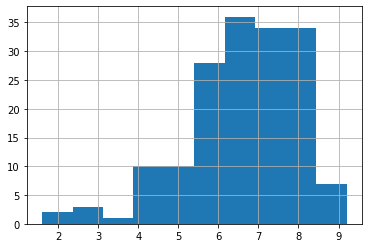

In [64]:
df1.query('platform == "XOne" and user_score != "9999"')['user_score'].hist()

In [65]:
df1.query('platform == "PC"  and user_score != "9999"')['user_score'].var()

2.901154315133451

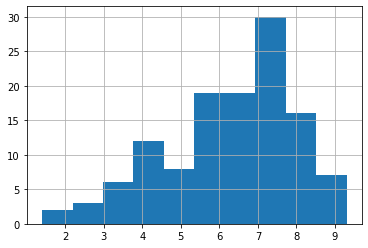

In [66]:
df1.query('platform == "PC" and user_score != "9999"')['user_score'].hist()

Распределение выборок стремится к нормальному, дисперсии выборок не равны.

В данном случае мы можем использовать Т-тест, указав в параметрах неравенство дисперсий.

Для начала определим уровень значимости = 5%, затем присвоим выборкам переменные и проведем Т-Тест.

In [67]:
alpha = 0.05

In [68]:
user_score_xone = df1.query('platform == "XOne" and user_score != "9999"')['user_score']

In [69]:
user_score_pc = df1.query('platform == "PC" and user_score != "9999"')['user_score'] 

In [70]:
ttest_ind(user_score_xone, user_score_pc, equal_var=False)

Ttest_indResult(statistic=1.5777606474474968, pvalue=0.11601398086668827)

По результатам теста pvalue выше уровня значимости, значит мы можем принять нулевую гипотезу и сделать вывод: *пользовательские рейтинги XOne и РС равны.*

### 4.2 Сравнение рейтингов Action  и Sports


Проверим гипотезу о неравенстве пользовательских рейтингов двух жанров - Action  и  Sports.

Сформулируем проверяемые гипотезы и зададим уровень значимости:

Н0: Средние пользовательские рейтинги жанров  Action  и  Sports равны

Н1: Средние пользовательские рейтинги жанров  Action  и  Sports НЕ равны

Теперь рассчитаем дисперсии выборок, построим графики их распределения и определимся с методом проверки.

In [71]:
df1.query('genre == "Action" and user_score != "9999"')['user_score'].var()

1.8984766584766581

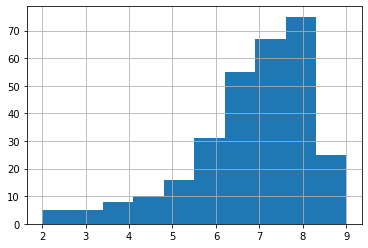

In [72]:
df1.query('genre == "Action" and user_score != "9999"')['user_score'].hist()

In [73]:
df1.query('genre == "Sports" and user_score != "9999"')['user_score'].var()

3.446979127609048

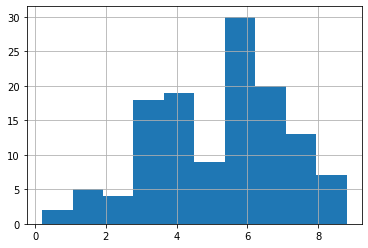

In [74]:
df1.query('genre == "Sports" and user_score != "9999"')['user_score'].hist()

Дисперсии двух выборок не равны (мы укажем это в параметре метода).

Распределение жанра `Action` похоже на нормальное, оно скошено в сторону высоких оценок, т.к. во всех регионов этот жанр находится в лидерах по продажам и логично предположить, что высоких оценок он получает больше.

Распределение спортивного жанра получилось с двумя пиками. 

Можем предположить, что два пика отражают картину по разным регионам: 
- в Америке и Европе жанр `Sports` входит в топ-3 самых продаваемых и соответственно получает много высоких оценок, 
- а в Японии этот жанр совершенно не популярен, и возможно оценки ниже среднего игры получают именно там

В идеале т-тест должен использоваться для нормального распределения, но в реальной жизни :) это не всегда выполнимо и, учитывая большой объем нашей выборки, данный метод может быть применен и в нашем случае:

In [75]:
alpha = 0.05

In [76]:
user_score_action = df1.query('genre == "Action" and user_score != "9999"')['user_score']

In [77]:
user_score_sports = df1.query('genre == "Sports" and user_score != "9999"')['user_score']

In [78]:
ttest_ind(user_score_action, user_score_sports, equal_var=False)

Ttest_indResult(statistic=8.384614718486121, pvalue=1.1825550382644557e-14)

Поскольку pvalue > alpha, мы можем принять нулевую гипотезу : *пользовательские оценки жанров `Action` и `Sports` равны.*

**Вывод**:   проверив статистические гипотезы мы подтвердили, что пользовательские рейтинги платформ `XOne` и `РС` равны.
Так же мы подтвердили равенство средних пользовательских рейтингов жанров `Action`  и `Sports`.

# 5. Вывод по проекту:


В проекте мы рассмотрели данные о продажах игр за весь период, доступный из открытых источников.

Поскольку нашей задачей является определение потенциально популярных продуктов на следующий год, нам необходимо было выявить факторы, влияющие на объемы продаж и популярность игр и платформ в целом.

Для точности прогноза мы выделили наш период исследования *с 2014 года до настоящего времени.* Выбор актуального периода был обусловлен полученными данными о средних сроках присутствия игровых платформ на рынке с момента их выпуска до полного выхода с рынка (замещения следующими версиями).

За актуальный период нами были отобраны 3 перспективные игровые платформы, который на данный момент, хоть и прошли свой пик популярности, но игры для них еще продаются миллионными тиражами - это *PS4, XOne и 3DS.* 
Эти платформы являются популярными не только в среднем по всему миру, но и лидируют в каждом из рассматриваемых регионов.

Важным фактором, определяющим объемы продаж игр является их жанр - в ходе исследования мы установили общемировые тенденции.
Самыми популярными жанрами являются:

- `Action`
- `Shooter`
- `Sports`
- `Role-Playing`

Остальные жанры приносят в разы меньше прибыли. Самыми низкими продажами отличаются:
- `Strategy`
- `Puzzle`

Интересно, что общемировые тенденции распространяются на американский и европейский регион, а вот в Японии картина с популярностью жанров сильно отличается: они предпочитают ролевые сюжеты и не любят спортивные.

Поскольку магазин "Стримчик", который заказал нам данное исследование, находится скорее всего в европейском регионе, то  будет логично запланировать на следующий год рекламу игр, ориентируясь на общемировой и европейский тренд.

Мы так же исследовали влияние экспертных и пользовательских оценок на объемы продаж игр. 
По итогам: оценки пользователей слишком разнородны и ни по одной платформ нет никакой зависимости между этим критерием и продажами. 

Оценки экспертов так же слабо влияют на продажи. Коэффициент корреляции довольно низкий. Полученные результаты скорее отражают логичное следствие - самые продаваемые игры по всем платформам имеют оценки критиков выше среднего.

Таким образом параметры оценок не являются ключевыми в прогнозировании объемов продаж на следующиий год.

Так же мы рассмотрели взаимосвязь популярности игр и рейтинга ESRB - по всем регионам картина схожая: большой объем продаж приходится на игры, которые в принципе еще не имеют проставленного рейтинга. Поэтому данный критерий мы тоже можем не принимать в расчет в нашем планировании.


Следующим шагом мы провели тестирование статистических гипотез и подтвердили предположение о том, что  пользовательские рейтинги XOne и РС равны. Так же мы подтвердили равенство средних пользовательских рейтингов жанров Action и Sports.

По результатам исследования мы рекомендуем магазину "Стримчик" при планировании расходов на рекламу в 2017 году бОльшую часть бюджета ориентировать на игры для платформ  *PS4, XOne и 3DS* в жанрах *Action, Shooter, Sports и Role-Playing*.

